In [ ]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn pillow tqdm opencv-python-headless torch torchvision torchaudio torchinfo
!pip install -q kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00


In [ ]:
!pip install gdown

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
import shutil
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as T_vision
import re
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchinfo import summary
from PIL import Image
import time
from google.colab import files
import json
import gdown
print("Imports and installations complete.")

Imports and installations complete.


In [ ]:
GDRIVE_FILE_ID_OR_LINK = "https://drive.google.com/file/d/1K_mgY-ZtFhv_g0obsqg3chH5TRiLc2ny/view?usp=drive_link"
MODEL_FILENAME_IN_COLAB = "best_phased_model_checkpoint.pth" # How it will be named in Colab

def download_model_from_gdrive(drive_id_or_link, output_filename, expected_min_size_bytes=100*1024*1024): # Min 100MB example
    """Downloads a file from Google Drive using gdown and checks size."""
    if os.path.exists(output_filename):
        # Optionally, check size here too if you want to re-download if too small
        # current_size = os.path.getsize(output_filename)
        # if current_size < expected_min_size_bytes:
        #     print(f"Existing file '{output_filename}' is too small ({current_size} bytes). Re-downloading.")
        #     os.remove(output_filename)
        # else:
        print(f"Model '{output_filename}' already exists locally. Skipping download.")
        return True

    print(f"Attempting to download model from Google Drive: {drive_id_or_link} as {output_filename}")
    try:
        # Using --fuzzy allows gdown to better handle various Google Drive link formats
        # Using output=output_filename is crucial
        gdown.download(url=drive_id_or_link, output=output_filename, quiet=False, fuzzy=True)

        if os.path.exists(output_filename):
            downloaded_size = os.path.getsize(output_filename)
            print(f"Model downloaded successfully as '{output_filename}'. Size: {downloaded_size / (1024*1024):.2f} MB.")
            if downloaded_size < expected_min_size_bytes: # Check if the size is reasonable
                print(f"WARNING: Downloaded file size ({downloaded_size} bytes) is smaller than expected minimum ({expected_min_size_bytes} bytes). File might be incomplete or corrupted.")
                return False # Or raise an error
            return True
        else:
            print(f"ERROR: Model download failed (file '{output_filename}' not found after gdown attempt).")
            return False
    except Exception as e:
        print(f"ERROR downloading model from Google Drive: {e}")
        return False

In [ ]:
EXPECTED_MIN_MODEL_SIZE_BYTES = 150 * 1024 * 1024 # Example: 150 MB

MODEL_DOWNLOADED_SUCCESSFULLY = download_model_from_gdrive(GDRIVE_FILE_ID_OR_LINK, MODEL_FILENAME_IN_COLAB, EXPECTED_MIN_MODEL_SIZE_BYTES)

if not MODEL_DOWNLOADED_SUCCESSFULLY:
    print("---------------------------------------------------------------------------")
    print("CRITICAL: Model download failed or the file is too small. Cannot proceed.")
    print(f"Please check your GDRIVE_FILE_ID_OR_LINK: '{GDRIVE_FILE_ID_OR_LINK}' and sharing permissions.")
    print("Then, re-run this cell and ensure the download completes successfully.")
    print("---------------------------------------------------------------------------")
    # You might want to raise an error here to stop execution if the model is critical
    # raise RuntimeError("Model download failed, cannot continue.")
else:
    # Now, MODEL_FILENAME_IN_COLAB is the path to use for loading
    # MODEL_CHECKPOINT_PATH = MODEL_FILENAME_IN_COLAB # Update this global if you use it elsewhere

    # Example: (This would be inside your run_bach_evaluation_v0 or similar)
    # model_to_evaluate, le_classes_cp = load_trained_model_from_path_v0(
    #     MODEL_FILENAME_IN_COLAB, # Use the local filename
    #     num_classes_expected=NUM_CLASSES_MODEL
    # )
    pass # Continue with the rest of your script logic that loads the model

Attempting to download model from Google Drive: https://drive.google.com/file/d/1K_mgY-ZtFhv_g0obsqg3chH5TRiLc2ny/view?usp=drive_link as best_phased_model_checkpoint.pth


Downloading...
From (original): https://drive.google.com/uc?id=1K_mgY-ZtFhv_g0obsqg3chH5TRiLc2ny
From (redirected): https://drive.google.com/uc?id=1K_mgY-ZtFhv_g0obsqg3chH5TRiLc2ny&confirm=t&uuid=3929b676-5b6e-4417-bb52-a58676e8a0c8
To: /content/best_phased_model_checkpoint.pth
100%|██████████| 850M/850M [00:08<00:00, 104MB/s] 

Model downloaded successfully as 'best_phased_model_checkpoint.pth'. Size: 810.99 MB.


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

MODEL_CHECKPOINT_PATH = "best_phased_model_checkpoint.pth" # Expect this to be uploaded by you

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

BATCH_SIZE_FOR_STATS_CALC = 64
NUM_WORKERS_PROCESSING = 2
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Label mapping (must match your original BreaKHis LabelEncoder)
ORIGINAL_BREAKHIS_LABEL_CLASSES = ['benign', 'malignant'] # e.g. benign=0, malignant=1
NUM_CLASSES_MODEL = len(ORIGINAL_BREAKHIS_LABEL_CLASSES)
print(f"Model trained for classes: {ORIGINAL_BREAKHIS_LABEL_CLASSES}")

# Placeholder for BreaKHis global stats - will be calculated
breakhis_global_lab_stats = None

print("Configuration set.")

Using device: cuda
Model trained for classes: ['benign', 'malignant']
Configuration set.


In [ ]:
def setup_kaggle_api():
    print("Setting up Kaggle API...")
    if os.path.exists('/root/.kaggle/kaggle.json'):
        print("Kaggle API already configured.")
        return True
    try:
        os.remove('/root/.kaggle/kaggle.json')
    except OSError: pass
    try:
        print("Please upload your kaggle.json API key:")
        uploaded = files.upload()
        if 'kaggle.json' not in uploaded:
            raise FileNotFoundError("kaggle.json not found.")
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        print("Kaggle API configured successfully.")
        return True
    except Exception as e:
        print(f"Kaggle setup failed: {e}.")
        return False

KAGGLE_READY = setup_kaggle_api()


Setting up Kaggle API...
Please upload your kaggle.json API key:


Saving kaggle.json to kaggle.json
Kaggle API configured successfully.


In [ ]:
def download_and_organize_breakhis_for_stats():
    if not KAGGLE_READY:
        print("Skipping BreaKHis download as Kaggle API is not ready.")
        return None

    organized_images_root_dir = '/content/organized_breakhis_for_stats'
    benign_check_path = os.path.join(organized_images_root_dir, 'benign')
    if os.path.exists(benign_check_path) and os.listdir(benign_check_path):
        print(f"BreaKHis images already found in '{organized_images_root_dir}'. Skipping download/organization.")
        return organized_images_root_dir

    print("Downloading BreaKHis dataset (for stats)...")
    if os.path.exists("breakhis.zip"): os.remove("breakhis.zip")
    if os.path.exists("/content/breakhis_unzipped_temp"): shutil.rmtree("/content/breakhis_unzipped_temp")
    if os.path.exists(organized_images_root_dir): shutil.rmtree(organized_images_root_dir)

    !kaggle datasets download -d ambarish/breakhis -p /content/ -q # Downloads breakhis.zip to /content/
    if not os.path.exists("/content/breakhis.zip"):
        print("ERROR: breakhis.zip not found after download.")
        return None

    print("Unzipping BreaKHis dataset...")
    os.makedirs("/content/breakhis_unzipped_temp", exist_ok=True)
    !unzip -q /content/breakhis.zip -d /content/breakhis_unzipped_temp
    # os.remove("/content/breakhis.zip") # Clean up zip

    source_base_dir_bh = '/content/breakhis_unzipped_temp/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
    if not os.path.exists(source_base_dir_bh):
        print(f"ERROR: BreaKHis source path not found: {source_base_dir_bh}")
        print("Listing contents of /content/breakhis_unzipped_temp to debug:")
        !ls -R /content/breakhis_unzipped_temp
        return None

    os.makedirs(os.path.join(organized_images_root_dir, 'benign'), exist_ok=True)
    os.makedirs(os.path.join(organized_images_root_dir, 'malignant'), exist_ok=True)

    def copy_images_local(source_path, destination_path_class):
        print(f"Copying from {source_path} to {destination_path_class}")
        for root, _, files_list in os.walk(source_path):
            for file_item in files_list:
                if file_item.lower().endswith('.png'):
                    src_file = os.path.join(root, file_item)
                    dst_file = os.path.join(destination_path_class, file_item)
                    counter = 1
                    base_name, ext = os.path.splitext(file_item)
                    while os.path.exists(dst_file):
                        dst_file = os.path.join(destination_path_class, f"{base_name}_{counter}{ext}")
                        counter += 1
                    shutil.copy2(src_file, dst_file)
        print(f"Finished copying to {destination_path_class}")

    copy_images_local(os.path.join(source_base_dir_bh, 'benign'), os.path.join(organized_images_root_dir, 'benign'))
    copy_images_local(os.path.join(source_base_dir_bh, 'malignant'), os.path.join(organized_images_root_dir, 'malignant'))
    print("BreaKHis images organized for stats calculation.")
    shutil.rmtree("/content/breakhis_unzipped_temp") # Clean up temp unzip dir
    return organized_images_root_dir

In [ ]:
def create_breakhis_stats_metadata(organized_dir):
    data = []
    for label_type in ['benign', 'malignant']:
        class_dir = os.path.join(organized_dir, label_type)
        if not os.path.isdir(class_dir): continue
        for fname in os.listdir(class_dir):
            if fname.lower().endswith((".png", ".jpg", ".jpeg", ".tif")): # Accept common image formats
                data.append({'image_path': os.path.join(class_dir, fname)})
    if not data: return None
    return pd.DataFrame(data)

# --- Calculate BreaKHis LAB Statistics (Online version) ---
def calculate_dataset_lab_stats_online(metadata_df, sample_size=None):
    print(f"Calculating LAB statistics ONLINE from {len(metadata_df)} images (sample_size={sample_size or len(metadata_df)})...")
    channel_stats = [{'count': 0, 'mean': 0.0, 'M2': 0.0} for _ in range(3)]
    df_to_sample = metadata_df
    if sample_size and len(metadata_df) > sample_size:
        df_to_sample = metadata_df.sample(n=sample_size, random_state=SEED)

    for img_path in tqdm(df_to_sample['image_path'], desc="Processing BreaKHis for Stats"):
        try:
            img_pil = Image.open(img_path).convert('RGB')
            img_np_rgb = np.array(img_pil)
            img_lab = cv2.cvtColor(img_np_rgb, cv2.COLOR_RGB2LAB).astype(float)
            for i in range(3):
                pixels = img_lab[:,:,i].flatten()
                for x in pixels:
                    channel_stats[i]['count'] += 1
                    delta = x - channel_stats[i]['mean']
                    channel_stats[i]['mean'] += delta / channel_stats[i]['count']
                    delta2 = x - channel_stats[i]['mean']
                    channel_stats[i]['M2'] += delta * delta2
        except Exception as e:
            print(f"Skipping {img_path} for stats due to error: {e}")

    final_means, final_stds = [], []
    all_counts_zero = all(cs['count'] == 0 for cs in channel_stats)
    if all_counts_zero:
        print("Error: No pixel data processed from BreaKHis. Cannot compute statistics.")
        return None

    for i in range(3):
        count, mean_val, M2_val = channel_stats[i]['count'], channel_stats[i]['mean'], channel_stats[i]['M2']
        final_means.append(mean_val if count > 0 else 0.0)
        variance = M2_val / count if count > 0 else 0
        final_stds.append(np.sqrt(variance) if variance >= 0 else 0.0)
    stats = {'means': final_means, 'stds': final_stds}
    print(f"Calculated BreaKHis Dataset LAB Means (Online): {stats['means']}")
    print(f"Calculated BreaKHis Dataset LAB Stds (Online): {stats['stds']}")
    return stats

In [ ]:
if KAGGLE_READY:
    organized_breakhis_path = download_and_organize_breakhis_for_stats()
    if organized_breakhis_path:
        breakhis_stats_df = create_breakhis_stats_metadata(organized_breakhis_path)
        if breakhis_stats_df is not None and not breakhis_stats_df.empty:
            breakhis_global_lab_stats = calculate_dataset_lab_stats_online(breakhis_stats_df, sample_size=2000) # Sample BreaKHis
if breakhis_global_lab_stats is None:
    print("Using FALLBACK SIMULATED BreaKHis LAB stats as actual calculation failed or was skipped.")
    breakhis_global_lab_stats = {'means': [150.0, 128.0, 128.0], 'stds': [40.0, 15.0, 15.0]}

Dataset URL: https://www.kaggle.com/datasets/ambarish/breakhis
License(s): unknown
Unzipping BreaKHis dataset...
Copying from /content/breakhis_unzipped_temp/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign to /content/organized_breakhis_for_stats/benign
Finished copying to /content/organized_breakhis_for_stats/benign
Copying from /content/breakhis_unzipped_temp/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant to /content/organized_breakhis_for_stats/malignant
Finished copying to /content/organized_breakhis_for_stats/malignant
BreaKHis images organized for stats calculation.
Calculating LAB statistics ONLINE from 7909 images (sample_size=2000)...


Processing BreaKHis for Stats:   0%|          | 0/2000 [00:00<?, ?it/s]

Calculated BreaKHis Dataset LAB Means (Online): [np.float64(180.77303722737406), np.float64(148.5958863834724), np.float64(116.52933380071916)]
Calculated BreaKHis Dataset LAB Stds (Online): [np.float64(35.43960364837374), np.float64(17.545317519936784), np.float64(11.058753513174233)]


In [ ]:
class HybridModel(nn.Module):
    def __init__(self, backbone1, backbone2, num_classes):
        super().__init__()
        self.effnet_feature_extractor = backbone1.features
        self.backbone2 = backbone2
        vit_original_head = self.backbone2.heads
        self.backbone2.heads = nn.Identity()

        if isinstance(backbone1.classifier, nn.Sequential) and \
           len(backbone1.classifier) > 1 and \
           isinstance(backbone1.classifier[1], nn.Linear):
            effnet_out_dim = backbone1.classifier[1].in_features
        elif isinstance(backbone1.classifier, nn.Linear):
             effnet_out_dim = backbone1.classifier.in_features
        else:
            raise AttributeError("Could not determine EfficientNet output features.")

        if hasattr(vit_original_head, 'head') and isinstance(vit_original_head.head, nn.Linear):
            vit_out_dim = vit_original_head.head.in_features
        else:
            vit_out_dim = 768

        fusion_input_dim = effnet_out_dim + vit_out_dim
        fusion_hidden_dim = 1024
        self.fusion = nn.Sequential(
            nn.LayerNorm(fusion_input_dim),
            nn.Linear(fusion_input_dim, fusion_hidden_dim),
            nn.GELU(),
            nn.LayerNorm(fusion_hidden_dim),
            nn.Dropout(0.6),
            nn.Linear(fusion_hidden_dim, fusion_hidden_dim)
        )
        classifier_hidden_dim = 512
        self.classifier = nn.Sequential(
            nn.LayerNorm(fusion_hidden_dim),
            nn.Linear(fusion_hidden_dim, classifier_hidden_dim),
            nn.GELU(),
            nn.Dropout(0.7),
            nn.Linear(classifier_hidden_dim, num_classes)
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x_image):
        effnet_features = self.effnet_feature_extractor(x_image)
        effnet_pooled = self.adaptive_pool(effnet_features)
        effnet_flat = torch.flatten(effnet_pooled, 1)

        if hasattr(self.backbone2, 'forward_features'):
            vit_output = self.backbone2.forward_features(x_image)
        else:
            x2_processed = self.backbone2._process_input(x_image)
            n = x2_processed.shape[0]
            batch_class_token = self.backbone2.class_token.expand(n, -1, -1)
            x2_tokens = torch.cat([batch_class_token, x2_processed], dim=1)
            x2_encoded = self.backbone2.encoder(x2_tokens)
            vit_output = x2_encoded

        if vit_output.ndim == 3:
            vit_cls_token = vit_output[:, 0]
        else:
            vit_cls_token = vit_output
        combined_features = torch.cat([effnet_flat, vit_cls_token], dim=1)
        fused_features = self.fusion(combined_features)
        output_logits = self.classifier(fused_features)
        return output_logits
print("Original HybridModel class defined.")

Original HybridModel class defined.


In [ ]:
def opencv_reinhard_normalize(source_img_np_rgb, target_lab_stats):
    if source_img_np_rgb.dtype != np.uint8:
        source_img_np_rgb = source_img_np_rgb.astype(np.uint8)
    source_lab = cv2.cvtColor(source_img_np_rgb, cv2.COLOR_RGB2LAB).astype(float)
    target_means = target_lab_stats['means']
    target_stds = target_lab_stats['stds']
    normalized_lab = np.zeros_like(source_lab)
    for i in range(3):
        source_mean = np.mean(source_lab[:,:,i])
        source_std  = np.std(source_lab[:,:,i])
        channel = source_lab[:,:,i]
        channel = (channel - source_mean) * (target_stds[i] / (source_std + 1e-7)) + target_means[i]
        normalized_lab[:,:,i] = channel
    normalized_lab[:,:,0] = np.clip(normalized_lab[:,:,0], 0, 255)
    normalized_lab[:,:,1] = np.clip(normalized_lab[:,:,1], 0, 255)
    normalized_lab[:,:,2] = np.clip(normalized_lab[:,:,2], 0, 255)
    normalized_rgb = cv2.cvtColor(normalized_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)
    return normalized_rgb

In [ ]:
class NewDatasetForTTA(Dataset):
    def __init__(self, metadata_df, use_stain_normalization=False, target_lab_stats_for_norm=None):
        self.metadata = metadata_df.reset_index(drop=True)
        self.use_stain_normalization = use_stain_normalization
        self.target_lab_stats_for_norm = target_lab_stats_for_norm
        if self.use_stain_normalization and self.target_lab_stats_for_norm is None:
            print("Warning: Stain norm enabled for NewDatasetForTTA but no target_lab_stats provided. Will be skipped.")
            self.use_stain_normalization = False

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_path = self.metadata.iloc[idx]['image_path']
        label = self.metadata.iloc[idx]['encoded_label']
        try:
            image_pil = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"ERROR loading image {img_path} for TTA: {e}")
            return None, None
        if self.use_stain_normalization and self.target_lab_stats_for_norm:
            try:
                image_np_rgb = np.array(image_pil)
                if not (image_np_rgb.shape[0] < 16 or image_np_rgb.shape[1] < 16) :
                    normalized_rgb_np = opencv_reinhard_normalize(image_np_rgb, self.target_lab_stats_for_norm)
                    image_pil = Image.fromarray(normalized_rgb_np)
            except Exception as e:
                print(f"Error during TTA stain normalization for {img_path}: {e}. Using original PIL.")
        return image_pil, label
print("Normalization helper and NewDatasetForTTA defined.")

Normalization helper and NewDatasetForTTA defined.


In [ ]:
def load_trained_model_from_path_v0(checkpoint_path_local, num_classes_expected):
    if not os.path.exists(checkpoint_path_local):
        print(f"ERROR: Model checkpoint file not found locally at {checkpoint_path_local}.")
        return None, None

    effnet_base = models.efficientnet_v2_s(weights=None)
    vit_base = models.vit_b_16(weights=None)

    # Instantiate model (it will be on CPU by default)
    model = HybridModel(
        backbone1=effnet_base,
        backbone2=vit_base,
        num_classes=num_classes_expected
    )
    print(f"Loading model checkpoint from: {checkpoint_path_local}")
    try:
        # Load checkpoint TO THE CPU FIRST, then load state_dict, then move model to DEVICE
        # This is often more robust than map_location=DEVICE if the model itself isn't on DEVICE yet.
        # Alternatively, ensure model is on DEVICE before load_state_dict if map_location=DEVICE is used.
        checkpoint = torch.load(checkpoint_path_local, map_location=torch.device('cpu'), weights_only=False) # Load to CPU

        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict']) # Load into CPU model
            print("Model state_dict loaded successfully (to CPU model instance).")

            # === NOW MOVE THE ENTIRE MODEL TO THE TARGET DEVICE ===
            model.to(DEVICE)
            print(f"Model moved to {DEVICE}.")
            # ======================================================

            le_classes_from_cp = checkpoint.get('label_encoder_classes', None)
            if le_classes_from_cp is not None and isinstance(le_classes_from_cp, np.ndarray):
                le_classes_from_cp = le_classes_from_cp.tolist()
            return model, le_classes_from_cp
        else:
            print("ERROR: 'model_state_dict' not found in checkpoint.")
            return None, None
    except Exception as e:
        print(f"ERROR loading checkpoint: {e}")
        import traceback
        traceback.print_exc() # Add this for more detail
        return None, None

def prepare_new_dataset_metadata(new_dataset_base_dir, breakhis_le_classes_list):
    print(f"Preparing metadata for new dataset from base: {new_dataset_base_dir}")
    data = []
    # This new dataset has 'Benign' and 'Malignant' subfolders
    for class_name_str in breakhis_le_classes_list: # e.g., 'benign', 'malignant'
        # The Kaggle dataset uses title case for folder names
        class_folder_name = class_name_str.capitalize()
        class_dir_path = os.path.join(new_dataset_base_dir, class_folder_name)

        if not os.path.isdir(class_dir_path):
            print(f"Warning: Expected class directory not found: {class_dir_path}")
            continue

        for filename in os.listdir(class_dir_path):
            if filename.lower().endswith((".png", ".jpg", ".jpeg", ".tif")): # Common image extensions
                img_path = os.path.join(class_dir_path, filename)
                data.append({'image_path': img_path, 'label_str': class_name_str})

    if not data:
        print(f"ERROR: No images found in {new_dataset_base_dir} with expected subfolder structure.")
        return None

    new_df = pd.DataFrame(data)

    # Encode labels using BreaKHis LabelEncoder logic
    temp_le = LabelEncoder()
    temp_le.classes_ = np.array(breakhis_le_classes_list)
    try:
        new_df['encoded_label'] = temp_le.transform(new_df['label_str'])
    except ValueError as e:
        print(f"ERROR encoding new dataset labels: {e}.")
        print(f"BreaKHis LE classes: {temp_le.classes_}")
        print(f"Unique string labels in new dataset: {new_df['label_str'].unique()}")
        return None

    print(f"Prepared new dataset metadata with {len(new_df)} images.")
    return new_df[['image_path', 'encoded_label']]

print("Model loading and new dataset metadata functions defined.")

Model loading and new dataset metadata functions defined.


In [ ]:
tta_pil_transforms = [
    T_vision.Compose([]),
    T_vision.RandomHorizontalFlip(p=1.0),
    T_vision.RandomVerticalFlip(p=1.0),
    T_vision.Compose([T_vision.RandomHorizontalFlip(p=1.0), T_vision.RandomVerticalFlip(p=1.0)]),
    T_vision.RandomRotation(degrees=(90,90)),
    T_vision.RandomRotation(degrees=(180,180)),
    T_vision.RandomRotation(degrees=(270,270)),
]
print(f"Defined {len(tta_pil_transforms)} TTA PIL variants.")

final_tta_processing_transform = T_vision.Compose([
    T_vision.Resize((224, 224)),
    T_vision.ToTensor(),
    T_vision.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
print("Defined final TTA processing transform.")


Defined 7 TTA PIL variants.
Defined final TTA processing transform.


In [ ]:
def prepare_new_dataset_metadata(new_dataset_root_unzip_dir, breakhis_le_classes_list):
    """
    Prepares metadata for the "Breast Cancer Cell (Histopathological images)" dataset from Kaggle.
    Assumes images are in a subfolder like 'Breast Cancer Histopathological Images/Images/'
    and filenames contain 'benign' or 'malignant'.
    """
    print(f"Preparing metadata for new dataset from root unzip: {new_dataset_root_unzip_dir}")
    data = []

    # Path to the directory containing all image files
    # Based on your example: /content/new_cancer_cell_dataset/Breast Cancer Histopathological Images/Images/
    actual_image_dir = os.path.join(new_dataset_root_unzip_dir, "Breast Cancer Histopathological Images", "Images")

    if not os.path.isdir(actual_image_dir):
        print(f"ERROR: Actual image directory not found: {actual_image_dir}")
        print("Please verify the unzipped structure. Listing contents of unzip root:")
        if os.path.exists(new_dataset_root_unzip_dir):
            !ls -R "{new_dataset_root_unzip_dir}" # List to help debug path
        return None

    print(f"Scanning for images in: {actual_image_dir}")
    found_images_count = 0

    for filename in os.listdir(actual_image_dir):
        # Check for common image extensions, including .tif and .tiff
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff")):
            img_path = os.path.join(actual_image_dir, filename)
            label_str = None

            # Parse label from filename (case-insensitive check)
            fn_lower = filename.lower()
            # Check for 'benign' ensuring it's not part of a longer word by mistake if patterns are complex
            # For this dataset, simple "in" check is likely fine
            if "benign" in fn_lower:
                # Map to the string 'benign' as defined in breakhis_le_classes_list[0]
                label_str = breakhis_le_classes_list[0]
            elif "malignant" in fn_lower: # Check if "malignant" is in the filename
                # Map to the string 'malignant' as defined in breakhis_le_classes_list[1]
                label_str = breakhis_le_classes_list[1]

            if label_str:
                data.append({'image_path': img_path, 'label_str': label_str})
                found_images_count += 1
            # else: # Optional: Print files for which labels couldn't be parsed
            #     print(f"Warning: Could not determine label for {filename}. Skipping.")

    if not data:
        print(f"ERROR: No images with parsable labels ('benign' or 'malignant' in filename) found in {actual_image_dir}.")
        return None

    new_df = pd.DataFrame(data)
    print(f"Found {found_images_count} images with parsable labels from filenames.")

    # Encode string labels ('benign', 'malignant') to numeric (0, 1)
    # using the BreaKHis LabelEncoder's class ordering
    temp_le = LabelEncoder()
    temp_le.classes_ = np.array(breakhis_le_classes_list) # e.g., ['benign', 'malignant']
    try:
        new_df['encoded_label'] = temp_le.transform(new_df['label_str'])
    except ValueError as e:
        print(f"ERROR encoding new dataset labels: {e}.")
        print(f"Ensure breakhis_le_classes_list ({breakhis_le_classes_list}) matches the parsed label_str values.")
        print(f"Unique string labels parsed from filenames: {new_df['label_str'].unique()}")
        return None

    print(f"Prepared new dataset metadata with {len(new_df)} images.")
    # For this model version, we only need image_path and encoded_label
    return new_df[['image_path', 'encoded_label']]

    # This dataset directly unzips into Benign/Malignant folders at the root of unzip dir
    new_dataset_metadata_df = prepare_bach_metadata_v0(
        NEW_DATASET_UNZIP_DIR, # Pass the root where "main_folder" is expected
        current_le_classes     # e.g., ['benign', 'malignant']
    )

    if new_dataset_metadata_df is None or new_dataset_metadata_df.empty:
        print("Failed to prepare metadata for the new dataset. Skipping evaluation.")
        return
    # Create Dataset for TTA
    new_eval_dataset_tta = NewDatasetForTTA(
        metadata_df=new_dataset_metadata_df,
        use_stain_normalization=True, # Enable stain normalization
        target_lab_stats_for_norm=breakhis_global_lab_stats # Use BreaKHis stats
    )
    print(f"Created new dataset for TTA with {len(new_eval_dataset_tta)} images.")

    # Evaluate on New Dataset with TTA
    print("\nStarting evaluation on the new dataset with TTA...")
    all_preds_new_tta, all_labels_new_tta, all_tta_avg_probs_new = [], [], []
    model_to_evaluate.eval()

    with torch.no_grad():
        for i in tqdm(range(len(new_eval_dataset_tta)), desc="TTA on New Dataset"):
            data_tuple = new_eval_dataset_tta[i]
            original_pil_image, label = data_tuple[0], data_tuple[1]
            if original_pil_image is None: continue

            tta_image_tensors = []
            for tta_transform_pil in tta_pil_transforms:
                augmented_pil = tta_transform_pil(original_pil_image)
                image_tensor = final_tta_processing_transform(augmented_pil)
                tta_image_tensors.append(image_tensor)
            if not tta_image_tensors: continue

            tta_batch = torch.stack(tta_image_tensors).to(DEVICE)
            outputs = model_to_evaluate(tta_batch)
            probabilities = torch.softmax(outputs, dim=1)
            avg_probabilities = torch.mean(probabilities, dim=0)
            _, predicted_class_idx = torch.max(avg_probabilities, dim=0)

            all_preds_new_tta.append(predicted_class_idx.cpu().item())
            all_labels_new_tta.append(label)
            all_tta_avg_probs_new.append(avg_probabilities.cpu().numpy()[1])

    if all_labels_new_tta:
        print("\n--- New Dataset Evaluation Results (TTA, BreaKHis Stats Norm) ---")
        new_accuracy = accuracy_score(all_labels_new_tta, all_preds_new_tta)
        new_auc = 0.0
        if len(np.unique(all_labels_new_tta)) > 1:
             new_auc = roc_auc_score(all_labels_new_tta, all_tta_avg_probs_new)
        else: print("Warning: Could not compute AUC for new dataset (single class).")
        print(f"  Accuracy:  {new_accuracy * 100:.2f}%")
        print(f"  AUC:       {new_auc:.4f}")
        # ... (add P, R, F1 as before) ...
        print("\nClassification Report (New Dataset with TTA):")
        print(classification_report(all_labels_new_tta, all_preds_new_tta, target_names=current_le_classes, zero_division=0))
        cm_new = confusion_matrix(all_labels_new_tta, all_preds_new_tta)
        plt.figure(figsize=(6,5)); sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', xticklabels=current_le_classes, yticklabels=current_le_classes)
        plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix - New Dataset (TTA)'); plt.show()
    else:
        print("No valid predictions for new dataset TTA evaluation.")


In [ ]:
def prepare_bach_metadata_v0(new_dataset_unzip_root, le_breakhis_classes_list):
    """
    Prepares metadata for the 'dina0808/bach-icar-2018' Kaggle dataset.
    Assumes structure: new_dataset_unzip_root / main_folder / [train_folder|testing_folder] / [Benign|Normal|InSitu|Invasive] / image.tif
    """
    print(f"Preparing BACH (dina0808) metadata from unzipped root: {new_dataset_unzip_root}")
    data = []
    image_count = 0

    # Path to the 'main_folder'
    main_folder_path = os.path.join(new_dataset_unzip_root, "main_folder")

    if not os.path.isdir(main_folder_path):
        print(f"ERROR: 'main_folder' not found in {new_dataset_unzip_root}")
        print("Please check the unzipped structure. Listing contents of unzip root:")
        if os.path.exists(new_dataset_unzip_root):
           !ls -R "{new_dataset_unzip_root}"
        return None

    # Iterate through train and test folders
    for split_folder_name in ["train_folder", "testing_folder"]:
        split_folder_path = os.path.join(main_folder_path, split_folder_name)
        if not os.path.isdir(split_folder_path):
            print(f"Warning: Split folder not found: {split_folder_path}")
            continue

        print(f"Scanning images in: {split_folder_path}")
        # Iterate through class folders (Benign, Normal, InSitu, Invasive)
        for original_class_name in ["Benign", "Normal", "InSitu", "Invasive"]:
            class_dir_path = os.path.join(split_folder_path, original_class_name)
            if not os.path.isdir(class_dir_path):
                # print(f"Info: Class directory not found (which is okay if not all classes in all splits): {class_dir_path}")
                continue

            for filename in os.listdir(class_dir_path):
                if filename.lower().endswith((".tif", ".tiff")): # BACH images are .tif
                    img_path = os.path.join(class_dir_path, filename)

                    # Map original BACH class folder name to your binary string label
                    label_str = None
                    original_class_lower = original_class_name.lower()
                    if original_class_lower in ['benign', 'normal']:
                        label_str = le_breakhis_classes_list[0] # e.g., 'benign'
                    elif original_class_lower in ['insitu', 'invasive']: # Note: 'InSitu' folder name
                        label_str = le_breakhis_classes_list[1] # e.g., 'malignant'

                    if label_str:
                        data.append({'image_path': img_path, 'label_str': label_str})
                        image_count += 1
                    # else:
                        # This should not happen if original_class_name is from the expected list
                        # print(f"Warning: Could not map original class folder '{original_class_name}' to binary label.")

    if not data:
        print(f"ERROR: No images found or processed from {main_folder_path} with expected subfolder structure.")
        return None

    new_df = pd.DataFrame(data)
    print(f"Found {image_count} total images from BACH (dina0808) dataset.")

    # Encode string labels ('benign', 'malignant') to numeric (0, 1)
    temp_le = LabelEncoder() # Use a fresh LabelEncoder instance for this mapping
    temp_le.classes_ = np.array(le_breakhis_classes_list) # Critical: Use BreaKHis class order
    try:
        new_df['encoded_label'] = temp_le.transform(new_df['label_str'])
    except ValueError as e:
        print(f"ERROR encoding BACH dataset labels: {e}.")
        print(f"BreaKHis LE classes used for mapping: {temp_le.classes_}")
        print(f"Unique string labels found and mapped from BACH: {new_df['label_str'].unique()}")
        return None

    print(f"Prepared BACH (dina0808) dataset metadata with {len(new_df)} images.")
    return new_df[['image_path', 'encoded_label']]

print("BACH (dina0808) metadata preparation function defined.")

BACH (dina0808) metadata preparation function defined.


In [ ]:
def run_new_dataset_evaluation(): # Renamed back for generality
    global breakhis_global_lab_stats
    global KAGGLE_READY, MODEL_CHECKPOINT_PATH # Ensure these are accessible

    if not os.path.exists(MODEL_CHECKPOINT_PATH):
        print(f"Model checkpoint '{MODEL_CHECKPOINT_PATH}' not available.")
        return

    model_to_evaluate, le_classes_cp = load_trained_model_from_path_v0( # Your existing loader for no-mag model
        MODEL_CHECKPOINT_PATH,
        num_classes_expected=NUM_CLASSES_MODEL
    )

    if model_to_evaluate is None: return
    current_le_classes = le_classes_cp if le_classes_cp is not None else ORIGINAL_BREAKHIS_LABEL_CLASSES
    print(f"Using LabelEncoder classes: {current_le_classes}")

    if breakhis_global_lab_stats is None:
        print("BreaKHis LAB stats not available. Stain norm will use fallback or be skipped.")
        if 'breakhis_global_lab_stats' not in globals() or globals()['breakhis_global_lab_stats'] is None:
             print("CRITICAL: Fallback LAB stats also not available. Exiting.")
             return

    # --- Download New Dataset (dina0808/bach-icar-2018) ---
    if not KAGGLE_READY:
        print("Kaggle API not ready. Skipping new dataset download.")
        return

    print("\nDownloading BACH (dina0808/bach-icar-2018) dataset...")
    NEW_DATASET_UNZIP_DIR = "/content/bach_dina0808_unzipped" # New distinct name
    NEW_DATASET_SLUG = "dina0808/bach-icar-2018" # <<<<----- NEW KAGGLE SLUG
    NEW_DATASET_ZIP_FILENAME = NEW_DATASET_SLUG.split('/')[-1] + ".zip" # e.g., "bach-icar-2018.zip"
    NEW_DATASET_ZIP_PATH = f"/content/{NEW_DATASET_ZIP_FILENAME}"

    # Check if already successfully unzipped (e.g., by checking for Photos/GroundTruth.csv)
    expected_gt_file_in_unzip = os.path.join(NEW_DATASET_UNZIP_DIR, "Photos", "GroundTruth.csv")
    # Some Kaggle datasets might have an extra top-level folder after unzipping
    # Example: /content/bach_dina0808_unzipped/ICIAR2018_BACH_Challenge/Photos/GroundTruth.csv
    expected_gt_file_in_unzip_nested = os.path.join(NEW_DATASET_UNZIP_DIR, "ICIAR2018_BACH_Challenge", "Photos", "GroundTruth.csv")


    if os.path.exists(expected_gt_file_in_unzip) or os.path.exists(expected_gt_file_in_unzip_nested):
        print(f"New BACH dataset seems already unzipped in/under {NEW_DATASET_UNZIP_DIR}.")
    else:
        if os.path.exists(NEW_DATASET_ZIP_PATH): os.remove(NEW_DATASET_ZIP_PATH)
        if os.path.exists(NEW_DATASET_UNZIP_DIR): shutil.rmtree(NEW_DATASET_UNZIP_DIR)

        print(f"Downloading {NEW_DATASET_SLUG} to /content/ ...")
        !kaggle datasets download -d {NEW_DATASET_SLUG} -p /content/ -q --force

        if not os.path.exists(NEW_DATASET_ZIP_PATH):
            print(f"ERROR: New dataset zip '{NEW_DATASET_ZIP_PATH}' not found after download.")
            !ls -lh /content/ # See what was actually downloaded
            # Try common alternative name if slug-based name fails
            alt_zip_name = "archive.zip"
            if os.path.exists(f"/content/{alt_zip_name}"):
                print(f"Found '/content/{alt_zip_name}', assuming this is it and renaming.")
                os.rename(f"/content/{alt_zip_name}", NEW_DATASET_ZIP_PATH)
            else:
                print("No suitable zip file found for new dataset.")
                return

        file_size_mb = os.path.getsize(NEW_DATASET_ZIP_PATH) / (1024*1024)
        print(f"New dataset zip file downloaded: {NEW_DATASET_ZIP_PATH}. Size: {file_size_mb:.2f} MB")
        # This dataset zip is ~2.34 GB. Min size check:
        if file_size_mb < 2000: # approx 2GB
             print(f"WARNING: Downloaded new dataset zip size ({file_size_mb:.2f}MB) seems too small.")

        os.makedirs(NEW_DATASET_UNZIP_DIR, exist_ok=True)
        print(f"Unzipping to {NEW_DATASET_UNZIP_DIR}...")
        !unzip -q "{NEW_DATASET_ZIP_PATH}" -d "{NEW_DATASET_UNZIP_DIR}"
        print("New dataset unzipped.")

        if not os.path.exists(NEW_DATASET_UNZIP_DIR) or not os.listdir(NEW_DATASET_UNZIP_DIR):
            print(f"ERROR: {NEW_DATASET_UNZIP_DIR} empty after unzip.")
            return

    # Determine the actual content directory for metadata preparation
    # This dataset (dina0808/bach-icar-2018) usually unzips directly into a structure
    # where 'Photos' and 'GroundTruth.csv' (within Photos) are accessible relative to NEW_DATASET_UNZIP_DIR
    # or sometimes within a single top-level folder like 'ICIAR2018_BACH_Challenge'.
    actual_new_dataset_content_dir = NEW_DATASET_UNZIP_DIR
    if os.path.isdir(os.path.join(NEW_DATASET_UNZIP_DIR, "ICIAR2018_BACH_Challenge")) and \
       os.path.exists(os.path.join(NEW_DATASET_UNZIP_DIR, "ICIAR2018_BACH_Challenge", "Photos", "GroundTruth.csv")):
        actual_new_dataset_content_dir = os.path.join(NEW_DATASET_UNZIP_DIR, "ICIAR2018_BACH_Challenge")
    elif not (os.path.isdir(os.path.join(NEW_DATASET_UNZIP_DIR, "Photos")) and \
              os.path.exists(os.path.join(NEW_DATASET_UNZIP_DIR, "Photos", "GroundTruth.csv"))):
        print(f"Warning: Standard BACH structure (Photos/GroundTruth.csv or ICIAR2018_BACH_Challenge/Photos/GroundTruth.csv) not immediately found in {NEW_DATASET_UNZIP_DIR}.")
        print("Listing contents to help debug:")
        !ls -R "{NEW_DATASET_UNZIP_DIR}"
        # Fallback: assume metadata prep can handle NEW_DATASET_UNZIP_DIR as its base.
        # This might need adjustment in prepare_bach_metadata_v0 if structure is very different.

    print(f"Using {actual_new_dataset_content_dir} as base for new dataset metadata preparation.")

    new_dataset_metadata_df = prepare_bach_metadata_v0( # Uses the function from Cell 6
        actual_new_dataset_content_dir,
        current_le_classes
    )

    if new_dataset_metadata_df is None or new_dataset_metadata_df.empty:
        print("Failed to prepare metadata for the new dataset. Skipping evaluation.")
        return

    # Create Dataset for TTA using the NEW dataset's metadata
    NEW_DATASET_SUBSET_SIZE = 500 # Or however many you want for testing
    if len(new_dataset_metadata_df) > NEW_DATASET_SUBSET_SIZE:
        print(f"Taking a subset of {NEW_DATASET_SUBSET_SIZE} from the new dataset for TTA.")
        # Stratified sampling
        from sklearn.model_selection import train_test_split
        new_dataset_metadata_subset_df, _ = train_test_split(
            new_dataset_metadata_df,
            train_size=NEW_DATASET_SUBSET_SIZE,
            stratify=new_dataset_metadata_df['encoded_label'],
            random_state=SEED
        )
    else:
        new_dataset_metadata_subset_df = new_dataset_metadata_df
        print(f"Using all {len(new_dataset_metadata_subset_df)} available images from the new dataset for TTA.")


    new_eval_dataset_tta = NewDatasetForTTA(
        metadata_df=new_dataset_metadata_subset_df, # Use the subset
        use_stain_normalization=True,
        target_lab_stats_for_norm=breakhis_global_lab_stats # Use BreaKHis stats
    )
    print(f"Created new dataset for TTA with {len(new_eval_dataset_tta)} images.")

    # Evaluate on New Dataset with TTA
    print("\nStarting evaluation on the new (BACH - dina0808) dataset with TTA...")
    # ... (The TTA evaluation loop and metrics printing code from your previous Cell 7
    #      can be used here. Just ensure variable names like all_preds_new_tta,
    #      all_labels_new_tta, etc. are used, and titles for plots/prints reflect
    #      that it's this new dataset.) ...
    all_preds_new_tta, all_labels_new_tta, all_tta_avg_probs_new = [], [], []
    model_to_evaluate.eval()

    with torch.no_grad():
        for i in tqdm(range(len(new_eval_dataset_tta)), desc="TTA on New Dataset"):
            data_tuple = new_eval_dataset_tta[i]
            original_pil_image, label = data_tuple[0], data_tuple[1]
            if original_pil_image is None: continue

            tta_image_tensors = []
            for tta_transform_pil in tta_pil_transforms:
                augmented_pil = tta_transform_pil(original_pil_image)
                image_tensor = final_tta_processing_transform(augmented_pil)
                tta_image_tensors.append(image_tensor)
            if not tta_image_tensors: continue

            tta_batch = torch.stack(tta_image_tensors).to(DEVICE)
            outputs = model_to_evaluate(tta_batch)
            probabilities = torch.softmax(outputs, dim=1)
            avg_probabilities = torch.mean(probabilities, dim=0)
            _, predicted_class_idx = torch.max(avg_probabilities, dim=0)

            all_preds_new_tta.append(predicted_class_idx.cpu().item())
            all_labels_new_tta.append(label)
            all_tta_avg_probs_new.append(avg_probabilities.cpu().numpy()[1])

    if all_labels_new_tta:
        print("\n--- New Dataset (BACH - dina0808) Evaluation Results (TTA, BreaKHis Stats Norm) ---")
        new_accuracy = accuracy_score(all_labels_new_tta, all_preds_new_tta)
        new_auc = 0.0
        if len(np.unique(all_labels_new_tta)) > 1:
             new_auc = roc_auc_score(all_labels_new_tta, all_tta_avg_probs_new)
        else: print("Warning: Could not compute AUC for new dataset (single class).")
        print(f"  Accuracy:  {new_accuracy * 100:.2f}%")
        print(f"  AUC:       {new_auc:.4f}")
        new_precision = precision_score(all_labels_new_tta, all_preds_new_tta, zero_division=0)
        new_recall = recall_score(all_labels_new_tta, all_preds_new_tta, zero_division=0)
        new_f1 = f1_score(all_labels_new_tta, all_preds_new_tta, zero_division=0)
        print(f"  Precision: {new_precision:.4f}")
        print(f"  Recall:    {new_recall:.4f}")
        print(f"  F1 Score:  {new_f1:.4f}")

        print("\nClassification Report (New Dataset - BACH dina0808 with TTA):")
        print(classification_report(all_labels_new_tta, all_preds_new_tta, target_names=current_le_classes, zero_division=0))
        cm_new = confusion_matrix(all_labels_new_tta, all_preds_new_tta)
        plt.figure(figsize=(6,5)); sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', xticklabels=current_le_classes, yticklabels=current_le_classes)
        plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix - New Dataset (BACH dina0808 TTA)'); plt.show()
    else:
        print("No valid predictions for new dataset TTA evaluation.")

STARTING EVALUATION ON NEW (BACH - dina0808) DATASET

All prerequisite checks passed. Proceeding with evaluation on the BACH (dina0808) dataset...
Loading model checkpoint from: best_phased_model_checkpoint.pth
Model state_dict loaded successfully (to CPU model instance).
Model moved to cuda.
Using LabelEncoder classes: ['benign', 'malignant']

Dataset URL: https://www.kaggle.com/datasets/dina0808/bach-icar-2018
License(s): unknown
100% 3.94G/3.95G [01:02<00:00, 137MB/s]
100% 3.95G/3.95G [01:02<00:00, 67.5MB/s]
New dataset zip file downloaded: /content/bach-icar-2018.zip. Size: 4049.65 MB
Unzipping to /content/bach_dina0808_unzipped...
New dataset unzipped.
Listing contents to help debug:
/content/bach_dina0808_unzipped:
main_folder

/content/bach_dina0808_unzipped/main_folder:
testing_folder	train_folder

/content/bach_dina0808_unzipped/main_folder/testing_folder:
Benign	InSitu	Invasive  Normal

/content/bach_dina0808_unzipped/main_folder/testing_folder/Benign:
b001.tif  b003.tif  b00

TTA on New Dataset:   0%|          | 0/440 [00:00<?, ?it/s]


--- New Dataset (BACH - dina0808) Evaluation Results (TTA, BreaKHis Stats Norm) ---
  Accuracy:  67.73%
  AUC:       0.6811
  Precision: 0.6726
  Recall:    0.6909
  F1 Score:  0.6816

Classification Report (New Dataset - BACH dina0808 with TTA):
              precision    recall  f1-score   support

      benign       0.68      0.66      0.67       220
   malignant       0.67      0.69      0.68       220

    accuracy                           0.68       440
   macro avg       0.68      0.68      0.68       440
weighted avg       0.68      0.68      0.68       440



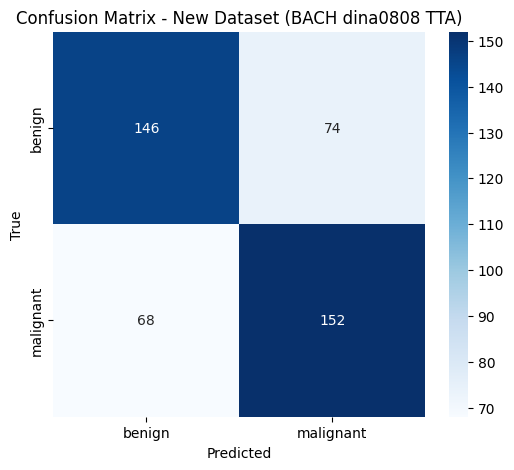


EVALUATION ON NEW (BACH - dina0808) DATASET COMPLETE.


In [ ]:
# --- Cell 8: Main Execution - Trigger Evaluation on New (BACH - dina0808) Dataset ---

if __name__ == '__main__' and '__file__' not in locals(): # Standard Colab check to run code
    print("===================================================")
    print("STARTING EVALUATION ON NEW (BACH - dina0808) DATASET")
    print("===================================================")

    # --- Sanity Checks for Critical Global Variables ---
    # These should have been set by previous cells.
    # MODEL_CHECKPOINT_PATH should be defined in Cell 2 (e.g., "best_phased_model_checkpoint.pth")
    # and the file should have been uploaded to Colab session storage.

    all_prerequisites_met = True

    # 1. Model Checkpoint Path
    if 'MODEL_CHECKPOINT_PATH' not in globals():
        print("ERROR: Global variable MODEL_CHECKPOINT_PATH is not defined. Please define it in Cell 2.")
        all_prerequisites_met = False
    elif not os.path.exists(MODEL_CHECKPOINT_PATH):
        print(f"ERROR: Model checkpoint file '{MODEL_CHECKPOINT_PATH}' does not exist in Colab session storage.")
        print("Please upload your '.pth' model file and ensure MODEL_CHECKPOINT_PATH in Cell 2 is correct.")
        all_prerequisites_met = False

    # 2. Kaggle API Readiness
    if 'KAGGLE_READY' not in globals() or not KAGGLE_READY:
        print("ERROR: KAGGLE_READY is not True. Please ensure Kaggle API (kaggle.json) was set up successfully in Cell 3.")
        all_prerequisites_met = False

    # 3. BreaKHis Normalization Stats
    if 'breakhis_global_lab_stats' not in globals() or breakhis_global_lab_stats is None:
        print("ERROR: breakhis_global_lab_stats is not available.")
        print("Please ensure Cell 3 (BreaKHis data processing and stats calculation) ran successfully and calculated these stats.")
        all_prerequisites_met = False

    # 4. Check for essential functions and class definitions from previous cells
    required_definitions = [
        'load_trained_model_from_path_v0',        # From Cell 6
        'prepare_bach_metadata_v0',               # From Cell 6 (for BACH structure)
        'NewDatasetForTTA',                       # From Cell 5
        'opencv_reinhard_normalize',              # From Cell 5
        'run_new_dataset_evaluation',             # From Cell 7 (updated for dina0808/bach-icar-2018)
        'HybridModel',                            # From Cell 4 (version without mag embedding)
        'tta_pil_transforms',                     # From Cell 7 (or a dedicated TTA cell)
        'final_tta_processing_transform'          # From Cell 7 (or a dedicated TTA cell)
    ]
    for func_name in required_definitions:
        if func_name not in globals():
            print(f"ERROR: Required function or class '{func_name}' is not defined. Please run all preceding cells.")
            all_prerequisites_met = False
            break

    # 5. Check for essential config variables from Cell 2
    required_configs = [
        'DEVICE', 'NUM_CLASSES_MODEL', 'ORIGINAL_BREAKHIS_LABEL_CLASSES',
        'IMAGENET_MEAN', 'IMAGENET_STD'
    ]
    for config_name in required_configs:
        if config_name not in globals():
            print(f"ERROR: Required configuration variable '{config_name}' is not defined. Please ensure Cell 2 ran.")
            all_prerequisites_met = False
            break

    if all_prerequisites_met:
        print("\nAll prerequisite checks passed. Proceeding with evaluation on the BACH (dina0808) dataset...")
        try:
            # The run_new_dataset_evaluation function is now tailored for the
            # "dina0808/bach-icar-2018" Kaggle dataset.
            run_new_dataset_evaluation() # This function is defined in your Cell 7
            print("\n===================================================")
            print("EVALUATION ON NEW (BACH - dina0808) DATASET COMPLETE.")
            print("===================================================")
        except Exception as e_main_eval:
            print(f"An unexpected error occurred during run_new_dataset_evaluation: {e_main_eval}")
            import traceback
            traceback.print_exc()
    else:
        print("\nOne or more prerequisites failed. Please review the error messages above and ensure all previous cells ran correctly.")

elif '__file__' in locals():
    print("Script is being imported. Skipping main execution block for BACH (dina0808) evaluation.")
else:
    print("Not in a main execution context (e.g., Colab cell run directly). To run, execute this cell after all setups.")